# Lovelytics Data Science Mini Project 
#### By : Prajwala Srivatsa <br> ps3900@nyu.edu

## A] Loading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('ggplot')
import seaborn as sns
import category_encoders as ce
import numpy as np
import datetime as dt
from pandas_profiling import ProfileReport

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

In [2]:
df2 = pd.read_csv("C:\\Users\\prajw\\Lovelytics\\resale-flat-prices-based-on-approval-date-2000-feb-2012.csv")
df2['Datetime'] = pd.to_datetime(df2['month'])
df2 = df2.set_index(['Datetime'])
df2 = df2.iloc[:,:][df2.month >= '2007-01']

In [3]:
df3 = pd.read_csv("C:\\Users\\prajw\\Lovelytics\\resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv")
df3['Datetime'] = pd.to_datetime(df3['month'])
df3 = df3.set_index(['Datetime'])
df3 = df3.drop(columns='remaining_lease')

In [4]:
df4 = pd.read_csv("C:\\Users\\prajw\\Lovelytics\\resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv")
df4['Datetime'] = pd.to_datetime(df4['month'])
df4 = df4.set_index(['Datetime'])

In [5]:
df5 = pd.read_csv("C:\\Users\\prajw\\Lovelytics\\resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")
# df5 without the data from 2019-2020 which is to be used for testing
#df5 = df5.iloc[:,:][df5.month < '2019-01']
df5['Datetime'] = pd.to_datetime(df5['month'])
df5 = df5.set_index(['Datetime'])
df5 = df5.drop(columns='remaining_lease')

In [6]:
df_combined = pd.concat([df2,df3,df4,df5])

In [7]:
df_combined['quarter'] = df_combined.index.quarter

In [8]:
df_combined.head(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,quarter
Datetime,,,,,,,,,,,
2007-01-01,2007-01,ANG MO KIO,3 ROOM,347,ANG MO KIO AVE 3,01 TO 03,67.0,Improved,1978,180000.0,1
2007-01-01,2007-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,132000.0,1
2007-01-01,2007-01,ANG MO KIO,3 ROOM,219,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1977,167000.0,1
2007-01-01,2007-01,ANG MO KIO,3 ROOM,225,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1978,165000.0,1
2007-01-01,2007-01,ANG MO KIO,3 ROOM,331,ANG MO KIO AVE 1,04 TO 06,68.0,New Generation,1981,166800.0,1


# B] Understanding the Data

## Profiling the Data

In [9]:
df_combined_ri = df_combined.reset_index()
profile = ProfileReport(df_combined_ri, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_notebook_iframe()

Please refer to the attached html sheet for the full report. <br>
The pandas profile report gives a lot of insight into the dataset. We can observe the corelation between various features and infer things like the 'quarter' in which the transaction occured does not affect the data much. This deviates from an intuitive understanding which is interesting. 

## Analysis

## 1. Mean prices over the years

We can observe an obvious spike in the resale prices in 2014. This may have been due to certain HDB related policy changes in Singapore that year.

In [18]:
def plot_mean(df):
    stat1 = df.resample("Y").mean()
    plt.plot(stat1.index,stat1['resale_price'])
    plt.xlabel('Year')
    plt.ylabel('House Price')
    #plt.legend(df['flat_model'])

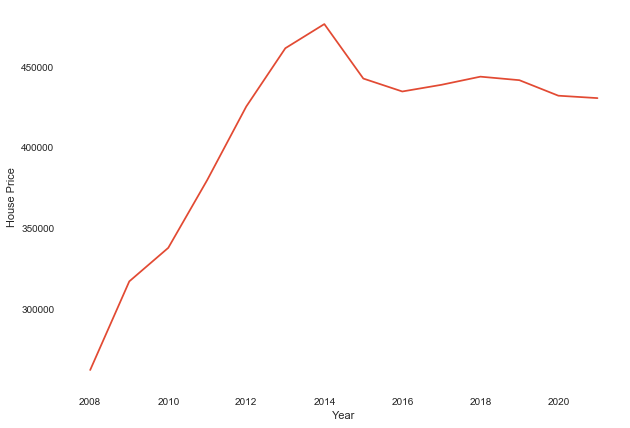

In [45]:
#df_combined = df_combined.set_index(['Datetime'])
plt.figure(figsize=(10,7))
plot_mean(df_combined)

## 2. Trend based on the model of the flat

### Converting flat_model to lower case

In [20]:
df_combined['flat_model'] = df_combined['flat_model'].str.lower()
df_combined['street_name'] = df_combined['street_name'].str.lower()
df_combined['town'] = df_combined['town'].str.lower()
df_combined['flat_type'] = df_combined['flat_type'].str.lower()
df_combined['year'] = df_combined.index.year
df_combined['no_of_resale_applications'] = ""


In [21]:
#df_combined = df_combined.set_index(['Datetime'])
df_combined['flat_model'].unique()

array(['improved', 'new generation', 'model a', 'adjoined flat',
       'apartment', 'maisonette', 'premium apartment', 'simplified',
       'model a-maisonette', 'standard', 'model a2', 'terrace',
       'multi generation', 'improved-maisonette', 'premium maisonette',
       '2-room', 'type s1', 'type s2', 'dbss', 'premium apartment loft'],
      dtype=object)

In [22]:
stat2_improved = df_combined.loc[df_combined['flat_model'] == 'improved']
stat2_newgen = df_combined.loc[df_combined['flat_model'] == 'new generation']
stat2_modela = df_combined.loc[df_combined['flat_model'] == 'model a']
stat2_std = df_combined.loc[df_combined['flat_model'] == 'standard']
stat2_simplified = df_combined.loc[df_combined['flat_model'] == 'simplified']
stat2_modelam = df_combined.loc[df_combined['flat_model'] == 'model a-maisonette']
stat2_apt = df_combined.loc[df_combined['flat_model'] == 'apartment']
stat2_mai = df_combined.loc[df_combined['flat_model'] == 'maisonette']
stat2_terr = df_combined.loc[df_combined['flat_model'] == 'terrace']
stat2_2r = df_combined.loc[df_combined['flat_model'] == '2-room']
stat2_imai = df_combined.loc[df_combined['flat_model'] == 'improved-maisonette']
stat2_mgen = df_combined.loc[df_combined['flat_model'] == 'multi generation']
stat2_papt = df_combined.loc[df_combined['flat_model'] == 'premium apartment']
stat2_aflat = df_combined.loc[df_combined['flat_model'] == 'adjoined flat']
stat2_pmai = df_combined.loc[df_combined['flat_model'] == 'premium maisonette']
stat2_ma2 = df_combined.loc[df_combined['flat_model'] == 'model a2']
stat2_s1 = df_combined.loc[df_combined['flat_model'] == 'type s1']
stat2_s2 = df_combined.loc[df_combined['flat_model'] == 'type s2']
stat2_dbss = df_combined.loc[df_combined['flat_model'] == 'dbss']
stat2_paptloft = df_combined.loc[df_combined['flat_model'] == 'premium apartment loft']

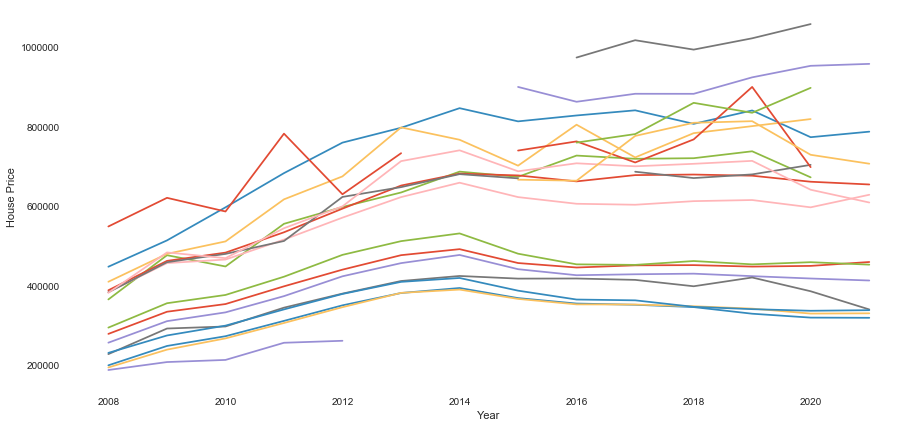

In [29]:
plt.figure(figsize=(15,7))
plot_mean(stat2_improved)
plot_mean(stat2_newgen)
plot_mean(stat2_modela)
plot_mean(stat2_std)
plot_mean(stat2_simplified)
plot_mean(stat2_modelam)
plot_mean(stat2_apt)
plot_mean(stat2_mai)
plot_mean(stat2_terr)
plot_mean(stat2_2r)
plot_mean(stat2_imai)
plot_mean(stat2_mgen)
plot_mean(stat2_papt)
plot_mean(stat2_aflat)
plot_mean(stat2_pmai)
plot_mean(stat2_ma2)
plot_mean(stat2_s1)
plot_mean(stat2_s2)
plot_mean(stat2_dbss)
plot_mean(stat2_paptloft)

We can observe that general trend (as expected) for each flat model is that the prices are increasing year on year and somewhat stabilizing towards 2020. But there is a noticable spike around 2014. This may be due to various market reasons such as policy change.

## 3. Obeserving Corelation Between Numerical Features

A correlation matrix is a good way to observe the influence of various features against the target feature. But this map can be directly plotted only for numerical data. <br>
Given the current dataset, there are very purely numerical features and most of the others are categorical features. 

PEARSON CORRELATION
                     floor_area_sqm  lease_commence_date  resale_price  \
floor_area_sqm             1.000000             0.452731      0.636567   
lease_commence_date        0.452731             1.000000      0.401988   
resale_price               0.636567             0.401988      1.000000   
quarter                    0.012397             0.018123      0.046245   
year                      -0.002286             0.113087      0.394296   

                      quarter      year  
floor_area_sqm       0.012397 -0.002286  
lease_commence_date  0.018123  0.113087  
resale_price         0.046245  0.394296  
quarter              1.000000  0.001462  
year                 0.001462  1.000000  


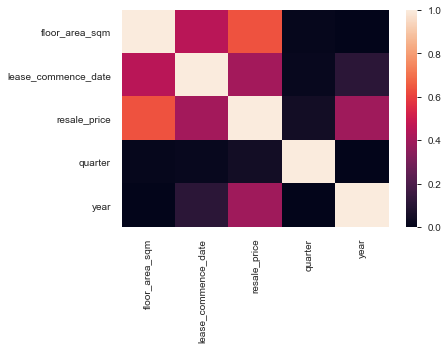

In [30]:
# correlation between attributes
print("PEARSON CORRELATION")
print(df_combined.corr(method="spearman"))
sns.heatmap(df_combined.corr(method="spearman"))
plt.savefig("heatmap_pearson.png")
plt.show()
plt.clf()
plt.close()

<b> From the above heatmap we can observe the obvious heavy corelation between floor area and resale price which should be the case </b>

## Visualizing categorical features

As a lot of the features we currently have are categorical, it is useful to plot them against the target variable to observe the spread of the data. <br>
Violin plots are informative as they not only show range but also frequency. <br>
This helps in understanding the trend of resale price based on each of the categorical data.

town
tampines           70595
yishun             60251
bedok              59330
jurong west        57966
woodlands          55978
ang mo kio         46580
hougang            43643
bukit batok        39068
choa chu kang      31792
bukit merah        29124
pasir ris          29097
toa payoh          27371
queenstown         24930
clementi           24894
geylang            24769
kallang/whampoa    23072
bukit panjang      22491
jurong east        22017
sengkang           20762
serangoon          20436
bishan             18838
punggol            10070
sembawang          10039
marine parade       7187
central area        6046
bukit timah         2181
lim chu kang          64
Name: town, dtype: int64


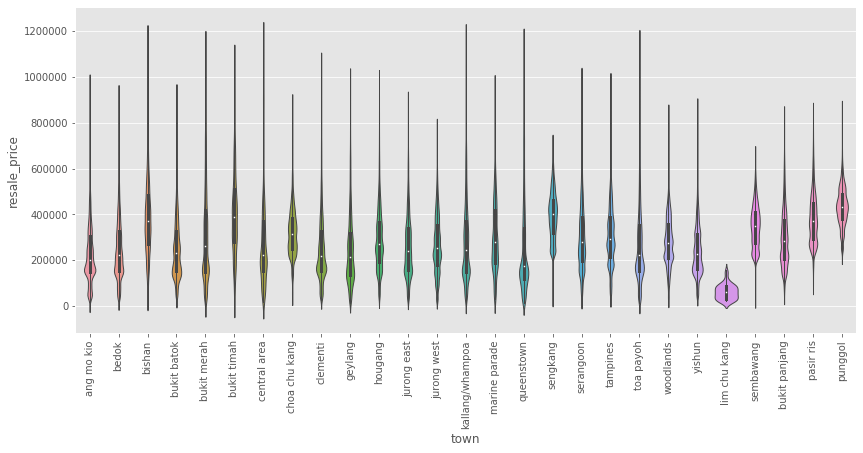

flat_type
4 room              293540
3 room              263332
5 room              161081
executive            59772
2 room                9128
1 room                1254
multi generation       279
multi-generation       205
Name: flat_type, dtype: int64


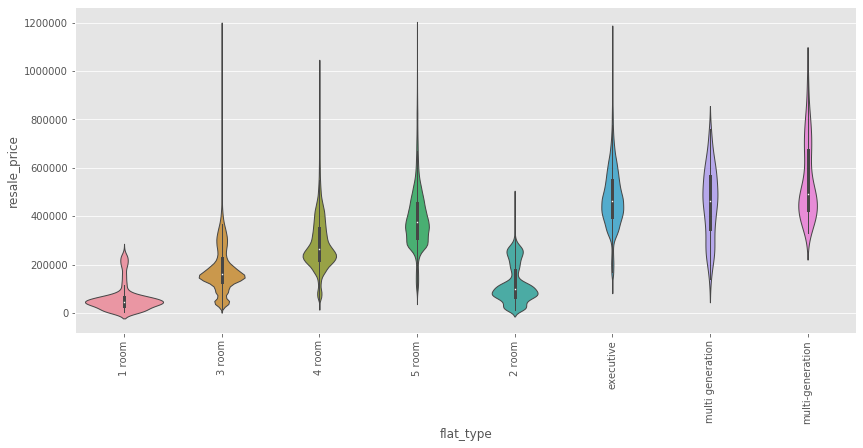

storey_range
04 TO 06    200768
07 TO 09    181266
01 TO 03    161975
10 TO 12    153207
13 TO 15     48633
16 TO 18     17750
19 TO 21      8728
22 TO 24      5541
01 TO 05      2700
06 TO 10      2474
25 TO 27      2261
11 TO 15      1259
28 TO 30       881
16 TO 20       265
34 TO 36       213
31 TO 33       200
37 TO 39       199
40 TO 42        97
21 TO 25        92
26 TO 30        39
46 TO 48        15
43 TO 45        12
49 TO 51         7
36 TO 40         7
31 TO 35         2
Name: storey_range, dtype: int64


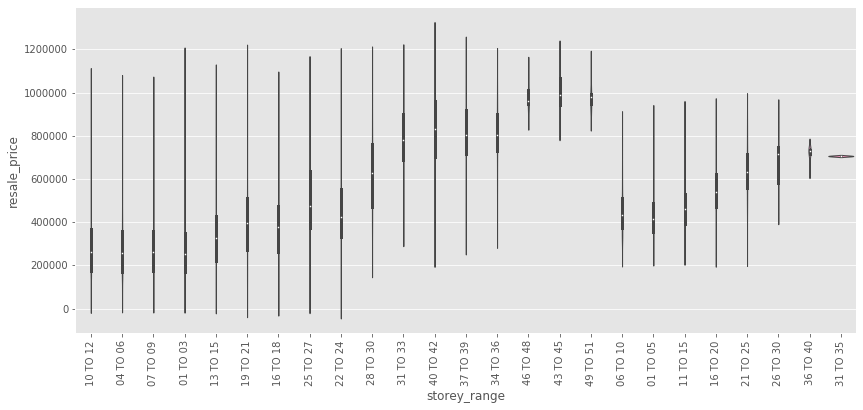

flat_model
model a                   215283
improved                  207927
new generation            172522
simplified                 52425
standard                   38752
premium apartment          31217
apartment                  30579
maisonette                 25795
model a2                    8699
model a-maisonette          1817
adjoined flat               1006
dbss                         913
terrace                      620
multi generation             484
type s1                      218
improved-maisonette          111
type s2                      102
premium maisonette            75
2-room                        38
premium apartment loft         8
Name: flat_model, dtype: int64


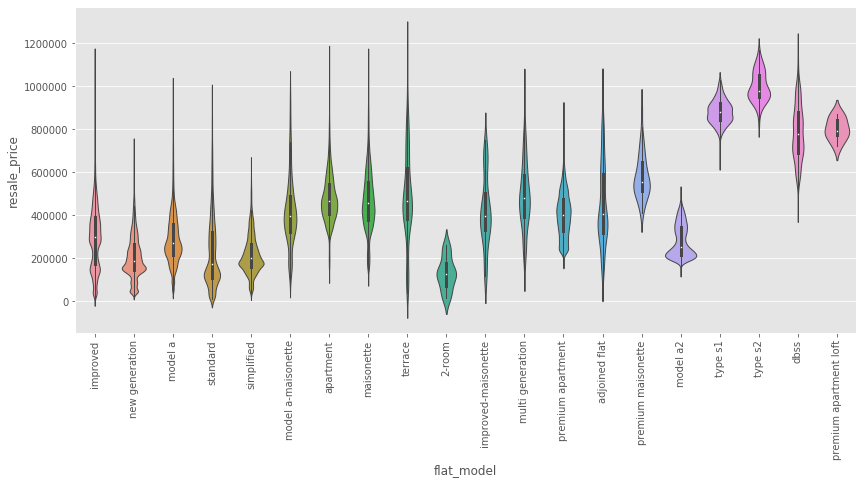

In [18]:
# Categorical features
catfeat = ['town','flat_type','storey_range','flat_model']
catdata=df_combined.loc[:, catfeat]
cat_values={}

for n in catfeat[0:len(catfeat)]:
    print(n)
    print(pd.value_counts(catdata[n]))
    ax = plt.subplots(figsize=(14, 6))
    plt.xticks(rotation='vertical')
    ax=sns.violinplot(x=n, y="resale_price", data=df_combined, linewidth=1)
    plt.show()

## 1. Visualizing the relation bw features and target variable

Understanding the spread of the data. We can infer that most of the apartments are transacted between <br> 300000 - 500000 and very few are worth 1100000 and above

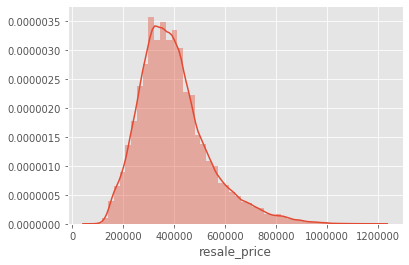

In [204]:
'''Distribution of resale price of data'''

sns.distplot(df_combined['resale_price'])

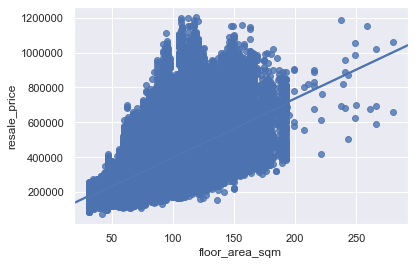

In [205]:
"""
Floor area vs Resale price --Regression plot
"""
sns.set(color_codes=True)
ax = sns.regplot(x="floor_area_sqm", y="resale_price", data=df_combined)

We can observe a kind of linear relation between floor area and resale price (which is expected), but we can also see the deviation from linearity which indicates the dependence on some other factors strongly influencing the price apart from square feet area. 

## Adding addional data - Number of resale applicants based on flat type

There are several other factors that affect the resale price of the HDB apartments like policy changes over the years and number of applicants based on the flat type. <br>
<br>
Considering the number of resale applicants here. <br>
It is typically observed that the costlier apartments in 'better' neighborhoods receive more number of applicants thus influencing the resale price of all categories due to supply demand relation.

Here I have includede the data of number of resale applications based on flat type in each quarter of the year from 2007. Hence I have used data only >= 2007 for training the model.

In [49]:
df_applicants = pd.read_csv("C:\\Users\\prajw\\Downloads\\number-of-resale-applications-registered-by-flat-type-quarterly\\number-of-resale-applications-registered-by-flat-type.csv")
df_applicants['flat_type'] = df_applicants.flat_type.apply(lambda x : x.replace('-',' '))
df_applicants['flat_type'] = df_applicants['flat_type'].str.lower()
df_applicants['flat_type'] = df_applicants.flat_type.apply(lambda x : x.replace('exec','executive'))
df_applicants.head(3)

,quarter,flat_type,no_of_resale_applications
0,2007-Q1,1 room,5
1,2007-Q1,2 room,67
2,2007-Q1,3 room,1908


In [50]:
df_applicants[(df_applicants['quarter'] == '2007-Q1') & (df_applicants['flat_type'] == '1-room')]['no_of_resale_applications']

Series([], Name: no_of_resale_applications, dtype: int64)

In [52]:
df_combined.head(3)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,quarter,year,no_of_resale_applications
Datetime,,,,,,,,,,,,,
2007-01-01,2007-01,ang mo kio,3 room,347,ang mo kio ave 3,01 TO 03,67.0,improved,1978,180000.0,1,2007,
2007-01-01,2007-01,ang mo kio,3 room,170,ang mo kio ave 4,04 TO 06,61.0,improved,1986,132000.0,1,2007,
2007-01-01,2007-01,ang mo kio,3 room,219,ang mo kio ave 1,07 TO 09,67.0,new generation,1977,167000.0,1,2007,


In [54]:
import datetime as dt
df_combined['quarter'] = df_combined.index.quarter
df_combined.head(4)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,quarter,year,no_of_resale_applications
Datetime,,,,,,,,,,,,,
2007-01-01,2007-01,ang mo kio,3 room,347,ang mo kio ave 3,01 TO 03,67.0,improved,1978,180000.0,1,2007,
2007-01-01,2007-01,ang mo kio,3 room,170,ang mo kio ave 4,04 TO 06,61.0,improved,1986,132000.0,1,2007,
2007-01-01,2007-01,ang mo kio,3 room,219,ang mo kio ave 1,07 TO 09,67.0,new generation,1977,167000.0,1,2007,
2007-01-01,2007-01,ang mo kio,3 room,225,ang mo kio ave 1,07 TO 09,67.0,new generation,1978,165000.0,1,2007,


## Cleaning Data

### Converting flat_model to lower case

In [9]:
df_combined['flat_model'] = df_combined['flat_model'].str.lower()
df_combined['street_name'] = df_combined['street_name'].str.lower()
df_combined['town'] = df_combined['town'].str.lower()
df_combined['flat_type'] = df_combined['flat_type'].str.lower()
df_combined['year'] = df_combined.index.year
df_combined['no_of_resale_applications'] = ""
df_combined.head(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,quarter,year,no_of_resale_applications
Datetime,,,,,,,,,,,,,
2007-01-01,2007-01,ang mo kio,3 room,347,ang mo kio ave 3,01 TO 03,67.0,improved,1978,180000.0,1,2007,
2007-01-01,2007-01,ang mo kio,3 room,170,ang mo kio ave 4,04 TO 06,61.0,improved,1986,132000.0,1,2007,
2007-01-01,2007-01,ang mo kio,3 room,219,ang mo kio ave 1,07 TO 09,67.0,new generation,1977,167000.0,1,2007,
2007-01-01,2007-01,ang mo kio,3 room,225,ang mo kio ave 1,07 TO 09,67.0,new generation,1978,165000.0,1,2007,
2007-01-01,2007-01,ang mo kio,3 room,331,ang mo kio ave 1,04 TO 06,68.0,new generation,1981,166800.0,1,2007,


In [34]:
df_combined_mini = df_combined[0:100]
df_combined_mini.head(5)

,Datetime,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,quarter,year,no_of_resale_applications
0,2007-01-01,2007-01,ang mo kio,3 room,347,ang mo kio ave 3,01 TO 03,67.0,improved,1978,180000.0,1,2007,
1,2007-01-01,2007-01,ang mo kio,3 room,170,ang mo kio ave 4,04 TO 06,61.0,improved,1986,132000.0,1,2007,
2,2007-01-01,2007-01,ang mo kio,3 room,219,ang mo kio ave 1,07 TO 09,67.0,new generation,1977,167000.0,1,2007,
3,2007-01-01,2007-01,ang mo kio,3 room,225,ang mo kio ave 1,07 TO 09,67.0,new generation,1978,165000.0,1,2007,
4,2007-01-01,2007-01,ang mo kio,3 room,331,ang mo kio ave 1,04 TO 06,68.0,new generation,1981,166800.0,1,2007,


In [159]:
df_combined['no_of_resale_applications'] = df_combined.apply(func , axis=1)

In [56]:
df_combined_mini['no_of_resale_applications'] = df_combined_mini.apply(func , axis=1)

In [57]:
def func(row):
    qtr = row['quarter']
    yr = row['year']
    f_type = row['flat_type']
    s = str(yr)+'-Q'+str(qtr)
    #print(f_type,s)
    no_app = df_applicants[(df_applicants['quarter'] == s) & (df_applicants['flat_type'] == f_type)]['no_of_resale_applications']
    #print(no_app)
    #row['no_of_resale_applications'] = no_app
    #return row['no_of_resale_applications']
    return no_app

In [58]:
df_combined_mini

,Datetime,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,quarter,year,no_of_resale_applications
0,2007-01-01,2007-01,ang mo kio,3 room,347,ang mo kio ave 3,01 TO 03,67.0,improved,1978,180000.0,1,2007,1908.0
1,2007-01-01,2007-01,ang mo kio,3 room,170,ang mo kio ave 4,04 TO 06,61.0,improved,1986,132000.0,1,2007,1908.0
2,2007-01-01,2007-01,ang mo kio,3 room,219,ang mo kio ave 1,07 TO 09,67.0,new generation,1977,167000.0,1,2007,1908.0
3,2007-01-01,2007-01,ang mo kio,3 room,225,ang mo kio ave 1,07 TO 09,67.0,new generation,1978,165000.0,1,2007,1908.0
4,2007-01-01,2007-01,ang mo kio,3 room,331,ang mo kio ave 1,04 TO 06,68.0,new generation,1981,166800.0,1,2007,1908.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2007-01-01,2007-01,ang mo kio,4 room,522,ang mo kio ave 5,07 TO 09,91.0,new generation,1980,280000.0,1,2007,NaN
96,2007-01-01,2007-01,ang mo kio,4 room,636,ang mo kio ave 6,04 TO 06,91.0,new generation,1980,249000.0,1,2007,NaN
97,2007-01-01,2007-01,ang mo kio,4 room,634,ang mo kio ave 6,01 TO 03,91.0,new generation,1980,243000.0,1,2007,NaN
98,2007-01-01,2007-01,ang mo kio,4 room,646,ang mo kio ave 6,07 TO 09,103.0,new generation,1980,245000.0,1,2007,NaN


In [161]:
df_combined

,Datetime,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,quarter,year,no_of_resale_applications
0,2007-01-01,2007-01,ang mo kio,3 room,347,ang mo kio ave 3,01 TO 03,67.0,improved,1978,180000.0,1,2007,NaN
1,2007-01-01,2007-01,ang mo kio,3 room,170,ang mo kio ave 4,04 TO 06,61.0,improved,1986,132000.0,1,2007,NaN
2,2007-01-01,2007-01,ang mo kio,3 room,219,ang mo kio ave 1,07 TO 09,67.0,new generation,1977,167000.0,1,2007,NaN
3,2007-01-01,2007-01,ang mo kio,3 room,225,ang mo kio ave 1,07 TO 09,67.0,new generation,1978,165000.0,1,2007,NaN
4,2007-01-01,2007-01,ang mo kio,3 room,331,ang mo kio ave 1,04 TO 06,68.0,new generation,1981,166800.0,1,2007,NaN
5,2007-01-01,2007-01,ang mo kio,3 room,333,ang mo kio ave 1,04 TO 06,68.0,new generation,1981,158000.0,1,2007,NaN
6,2007-01-01,2007-01,ang mo kio,3 room,331,ang mo kio ave 1,04 TO 06,68.0,new generation,1981,165000.0,1,2007,NaN
7,2007-01-01,2007-01,ang mo kio,3 room,404,ang mo kio ave 10,10 TO 12,67.0,new generation,1979,168000.0,1,2007,NaN
8,2007-01-01,2007-01,ang mo kio,3 room,405,ang mo kio ave 10,10 TO 12,67.0,new generation,1979,172000.0,1,2007,NaN
9,2007-01-01,2007-01,ang mo kio,3 room,419,ang mo kio ave 10,04 TO 06,74.0,new generation,1979,166000.0,1,2007,NaN


In [146]:
df_combined['town'].unique()

array(['ang mo kio', 'bedok', 'bishan', 'bukit batok', 'bukit merah',
       'bukit panjang', 'bukit timah', 'central area', 'choa chu kang',
       'clementi', 'geylang', 'hougang', 'jurong east', 'jurong west',
       'kallang/whampoa', 'marine parade', 'pasir ris', 'punggol',
       'queenstown', 'sembawang', 'sengkang', 'serangoon', 'tampines',
       'toa payoh', 'woodlands', 'yishun'], dtype=object)

# C] Data Cleaning and Pre-processing

This is one of the most important steps before training any model. <br>
Here I have converted each of the categorical data into numerical data so that it can be fed into the machine learning models. 

## 1. One hot encoding for categorical data

Encoding all data including testing data. <br>
To use the categorical data, we cannot do so directly because models only understand numerical data. <br>
<br>
One popular way of converting categorical data into numerical is through one hot encoding. <br>
This simply generates 'n' number of columns as number of categories in that particular feature and encodes a '1' if the data point belongs to that category or '0' if it does not.

In [10]:
df5 = pd.read_csv("C:\\Users\\prajw\\Lovelytics\\resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")
df5['Datetime'] = pd.to_datetime(df5['month'])
df5 = df5.set_index(['Datetime'])
df5 = df5.drop(columns='remaining_lease')
df_combined_all = pd.concat([df2,df3,df4,df5])
df_combined_all['flat_model'] = df_combined_all['flat_model'].str.lower()
df_combined_all['street_name'] = df_combined_all['street_name'].str.lower()
df_combined_all['town'] = df_combined_all['town'].str.lower()
df_combined_all['flat_type'] = df_combined_all['flat_type'].str.lower()
df_combined_all.head(3)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
Datetime,,,,,,,,,,
2007-01-01,2007-01,ang mo kio,3 room,347,ang mo kio ave 3,01 TO 03,67.0,improved,1978,180000.0
2007-01-01,2007-01,ang mo kio,3 room,170,ang mo kio ave 4,04 TO 06,61.0,improved,1986,132000.0
2007-01-01,2007-01,ang mo kio,3 room,219,ang mo kio ave 1,07 TO 09,67.0,new generation,1977,167000.0


### Splitting training and testing target variable resale_price

In [11]:
y_train = df_combined_all.iloc[:,-1][df_combined_all.month < '2019-01']
y_test = df_combined_all.iloc[:,-1][df_combined_all.month >= '2019-01']

In [12]:
df_combined_all['quarter'] = df_combined_all.index.quarter

catfeat = ['town','flat_type','flat_model']
datadum = df_combined_all
categories = catfeat[0:len(catfeat)]
for category in categories:
    series = datadum[category]
    dummies = pd.get_dummies(series, prefix=category)
    datadum = pd.concat([datadum, dummies], axis=1)
print(datadum.columns)
datadum.head(4)

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'quarter', 'town_ang mo kio', 'town_bedok', 'town_bishan',
       'town_bukit batok', 'town_bukit merah', 'town_bukit panjang',
       'town_bukit timah', 'town_central area', 'town_choa chu kang',
       'town_clementi', 'town_geylang', 'town_hougang', 'town_jurong east',
       'town_jurong west', 'town_kallang/whampoa', 'town_marine parade',
       'town_pasir ris', 'town_punggol', 'town_queenstown', 'town_sembawang',
       'town_sengkang', 'town_serangoon', 'town_tampines', 'town_toa payoh',
       'town_woodlands', 'town_yishun', 'flat_type_1 room', 'flat_type_2 room',
       'flat_type_3 room', 'flat_type_4 room', 'flat_type_5 room',
       'flat_type_executive', 'flat_type_multi-generation',
       'flat_model_2-room', 'flat_model_adjoined flat', 'flat_model_apartment',
       'flat_model_dbss', 'flat_model_improved',


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,flat_model_multi generation,flat_model_new generation,flat_model_premium apartment,flat_model_premium apartment loft,flat_model_premium maisonette,flat_model_simplified,flat_model_standard,flat_model_terrace,flat_model_type s1,flat_model_type s2
Datetime,,,,,,,,,,,,,,,,,,,,,
2007-01-01,2007-01,ang mo kio,3 room,347,ang mo kio ave 3,01 TO 03,67.0,improved,1978,180000.0,...,0,0,0,0,0,0,0,0,0,0
2007-01-01,2007-01,ang mo kio,3 room,170,ang mo kio ave 4,04 TO 06,61.0,improved,1986,132000.0,...,0,0,0,0,0,0,0,0,0,0
2007-01-01,2007-01,ang mo kio,3 room,219,ang mo kio ave 1,07 TO 09,67.0,new generation,1977,167000.0,...,0,1,0,0,0,0,0,0,0,0
2007-01-01,2007-01,ang mo kio,3 room,225,ang mo kio ave 1,07 TO 09,67.0,new generation,1978,165000.0,...,0,1,0,0,0,0,0,0,0,0


### Remove redundant columns and target variable

In [13]:
removefeats= ['month','town','flat_type','storey_range','flat_model','resale_price','block','lease_commence_date','street_name']
X = datadum.drop(removefeats, axis=1)

In [14]:
X.head(4)

,floor_area_sqm,quarter,town_ang mo kio,town_bedok,town_bishan,town_bukit batok,town_bukit merah,town_bukit panjang,town_bukit timah,town_central area,...,flat_model_multi generation,flat_model_new generation,flat_model_premium apartment,flat_model_premium apartment loft,flat_model_premium maisonette,flat_model_simplified,flat_model_standard,flat_model_terrace,flat_model_type s1,flat_model_type s2
Datetime,,,,,,,,,,,,,,,,,,,,,
2007-01-01,67.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007-01-01,61.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007-01-01,67.0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2007-01-01,67.0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Splitting training and testing data

In [15]:
X_train = X.loc[:'2018-12-31']
X_test = X.loc['2019-01-01':'2020-12-31']
print(X_train.shape,X_test.shape)

(276789, 55) (24113, 55)


# D] Model Interpretation 

## Standardizing Data

In [77]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(X_train)
x = pd.DataFrame(x, columns=X_train.columns)

In [78]:
x.head(5)

,floor_area_sqm,quarter,town_ang mo kio,town_bedok,town_bishan,town_bukit batok,town_bukit merah,town_bukit panjang,town_bukit timah,town_central area,...,flat_model_multi generation,flat_model_new generation,flat_model_premium apartment,flat_model_premium apartment loft,flat_model_premium maisonette,flat_model_simplified,flat_model_standard,flat_model_terrace,flat_model_type s1,flat_model_type s2
0,-1.216385,-1.400851,4.408489,-0.254088,-0.143084,-0.210142,-0.201318,-0.192245,-0.049259,-0.087247,...,-0.020209,-0.450905,-0.313548,-0.005376,-0.010058,-0.236582,-0.203484,-0.028776,-0.028075,-0.0192
1,-1.456963,-1.400851,4.408489,-0.254088,-0.143084,-0.210142,-0.201318,-0.192245,-0.049259,-0.087247,...,-0.020209,-0.450905,-0.313548,-0.005376,-0.010058,-0.236582,-0.203484,-0.028776,-0.028075,-0.0192
2,-1.216385,-1.400851,4.408489,-0.254088,-0.143084,-0.210142,-0.201318,-0.192245,-0.049259,-0.087247,...,-0.020209,2.217762,-0.313548,-0.005376,-0.010058,-0.236582,-0.203484,-0.028776,-0.028075,-0.0192
3,-1.216385,-1.400851,4.408489,-0.254088,-0.143084,-0.210142,-0.201318,-0.192245,-0.049259,-0.087247,...,-0.020209,2.217762,-0.313548,-0.005376,-0.010058,-0.236582,-0.203484,-0.028776,-0.028075,-0.0192
4,-1.176289,-1.400851,4.408489,-0.254088,-0.143084,-0.210142,-0.201318,-0.192245,-0.049259,-0.087247,...,-0.020209,2.217762,-0.313548,-0.005376,-0.010058,-0.236582,-0.203484,-0.028776,-0.028075,-0.0192


## PCA and Scree Plot

In [79]:
from sklearn.decomposition import PCA
pcamodel = PCA(n_components=6)
pca = pcamodel.fit_transform(x)
pca.shape

(276789, 6)

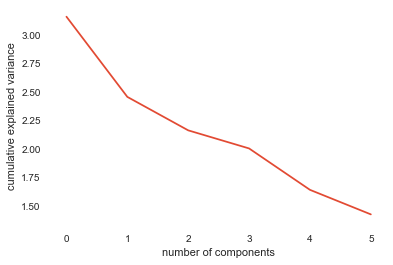

In [80]:
plt.plot(pcamodel.explained_variance_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

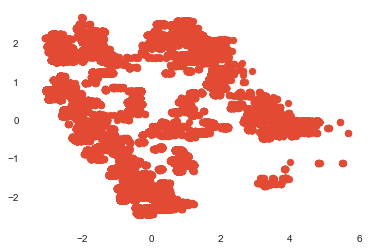

In [81]:
plt.scatter(pca[:, 0], pca[:, 1])

<bound method Artist.set of <matplotlib.axes._subplots.AxesSubplot object at 0x0000013C02987400>>

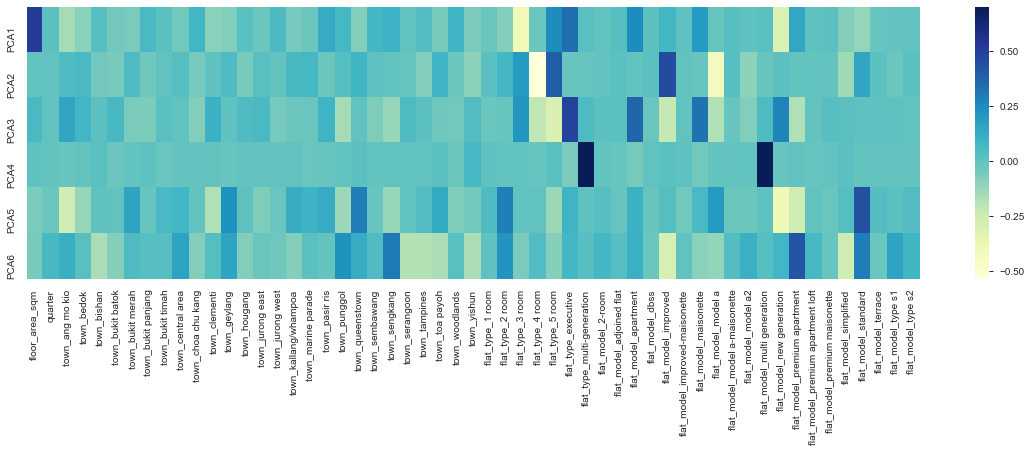

In [82]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax = sns.heatmap(pcamodel.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pcamodel.n_components_+1)],
                 xticklabels=list(x.columns))
#ax.set_aspect("equal")
ax.set

The above plot helps us understand how each of the features contribute or influence each of the principal components that can be used to represent the dataset. <br>
We know that typically , PC 1 is the most informative about how the data is spread and from the plot above we can see that 'floor_area_sqm' influences this component the most compared to all other features. <br>

# E] Training Basic Regression Models

Linear: -8503718672.984, 5637344529.563


C:\Users\prajw\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450590042228369.9, tolerance: 43021969012115.37
  positive)
C:\Users\prajw\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 558119793846247.7, tolerance: 45895956671697.68
  positive)
C:\Users\prajw\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583895546478204.5, tolerance: 47128657986340.99
  positive)
C:\Users\prajw\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Lasso: -8504377595.663, 5638534424.335
DecisionTree: -7231774804.984, 5556083718.121


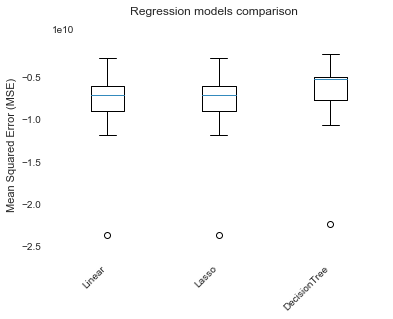

In [23]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error


folds   = 10
metric  = "neg_mean_squared_error"


# hold different regression models in a single dictionary
models = {}
models["Linear"]        = LinearRegression()
models["Lasso"]         = Lasso(tol=0.01)
models["DecisionTree"]  = DecisionTreeRegressor()
# models["RandomForest"]  = RandomForestRegressor()


# 10-fold cross validation for each model
model_results = []
model_names   = []
for model_name in models: 
    model   = models[model_name]
    k_fold  = KFold(n_splits=folds)
    results = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=metric)

    model_results.append(results)
    model_names.append(model_name)
    print("{}: {}, {}".format(model_name, round(results.mean(), 3), round(results.std(), 3)))

# box-whisker plot to compare regression models
figure = plt.figure()
figure.suptitle('Regression models comparison')
axis = figure.add_subplot(111)
plt.boxplot(model_results)
axis.set_xticklabels(model_names, rotation = 45, ha="right")
axis.set_ylabel("Mean Squared Error (MSE)")
plt.margins(0.05, 0.1)
plt.show()
plt.savefig("model_mse_scores.png")
plt.clf()
plt.close()

<b> Decision Tree

In [20]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# make predictions using the model
predictions_dt = dt.predict(X_test)
print("[INFO] MSE : {}".format(round(mean_squared_error(y_test, predictions_dt), 3)))

[INFO] MSE : 4479665993.712


In [21]:
r2_dt = r2_score(y_test, predictions_dt)
print('Decision Tree',r2_dt)

Decision Tree 0.8098395197901374


<b> Linear Regression

In [83]:
lr = LinearRegression()
lr.fit(X_train, y_train)
# make predictions using the model
predictions_lr = lr.predict(X_test)
print("[INFO] MSE : {}".format(round(mean_squared_error(y_test, predictions_lr), 3)))

[INFO] MSE : 7443420816.973


In [86]:
r2_lr = r2_score(y_test, predictions_lr)
print('Linear Regression',r2_lr)

Linear Regression 0.6840290148983046


### XGBoost

The above basic regression models did not perform very well as we can see from MSE values. <br>
<br>
Thus I decided to apply XGBoost Algorithm because when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered to perform best right now, even compared to neural networks. This is evident in the Regression model comparision boxplot above. 
<br>
<br>
Furthermore, XGBoost improves upon the base GBM framework through systems optimization and algorithmic enhancements. <br>
System optimization through:
<ol>
    <li> Parallelization
        <li> Tree Pruning
            <li> Hardware Optimization
    </ol>
Algorithmic Enhancement through:
<ol>
    <li> Regularization
        <li> Sparsity Awareness
            <li> Weighted Quantile Sketch
                <li> Cross-validation
    </ol>

In [47]:
!pip install xgboost

In [16]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
# make predictions
predictions = xgb_model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 45303.61506845374


In [18]:
print("R2 score XGBoost: {}".format(r2_score(y_test, predictions)))

R2 score XGBoost: 0.8141193278577823


#### Tuning hyperparameters to increase accuracy

In [90]:
# for hyper parameter tuning --
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV 

In [91]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=param_comb, scoring='r2', n_jobs=4, verbose=3, random_state=1001 )
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [24]:
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

NameError: name 'random_search' is not defined

# F] Feature Importance

### From Decision Tree

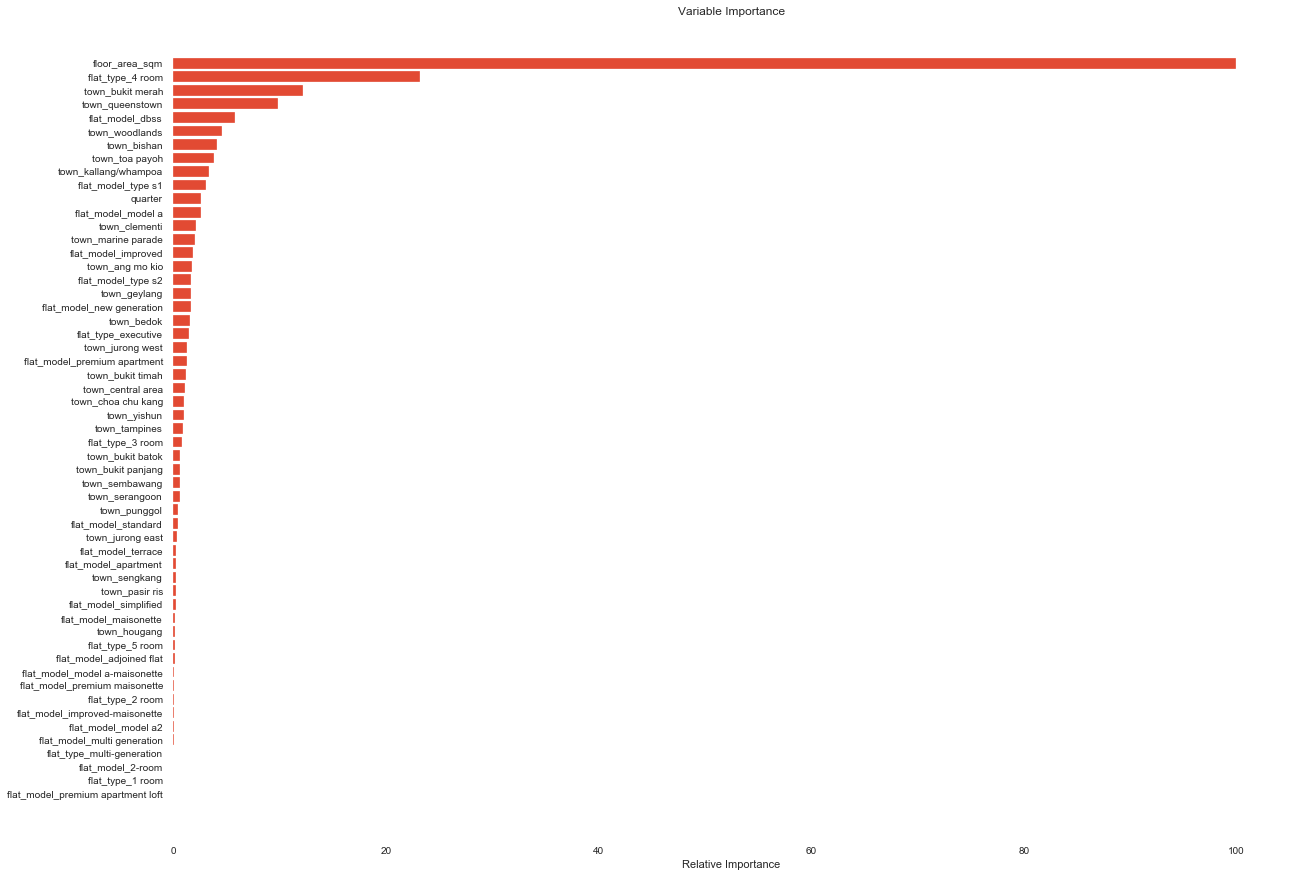

In [22]:
# plot model's feature importance
feature_importance = dt.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos        = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(20,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
plt.savefig("feature_importance_dt.png")
plt.clf()
plt.close()

### From XGBoost

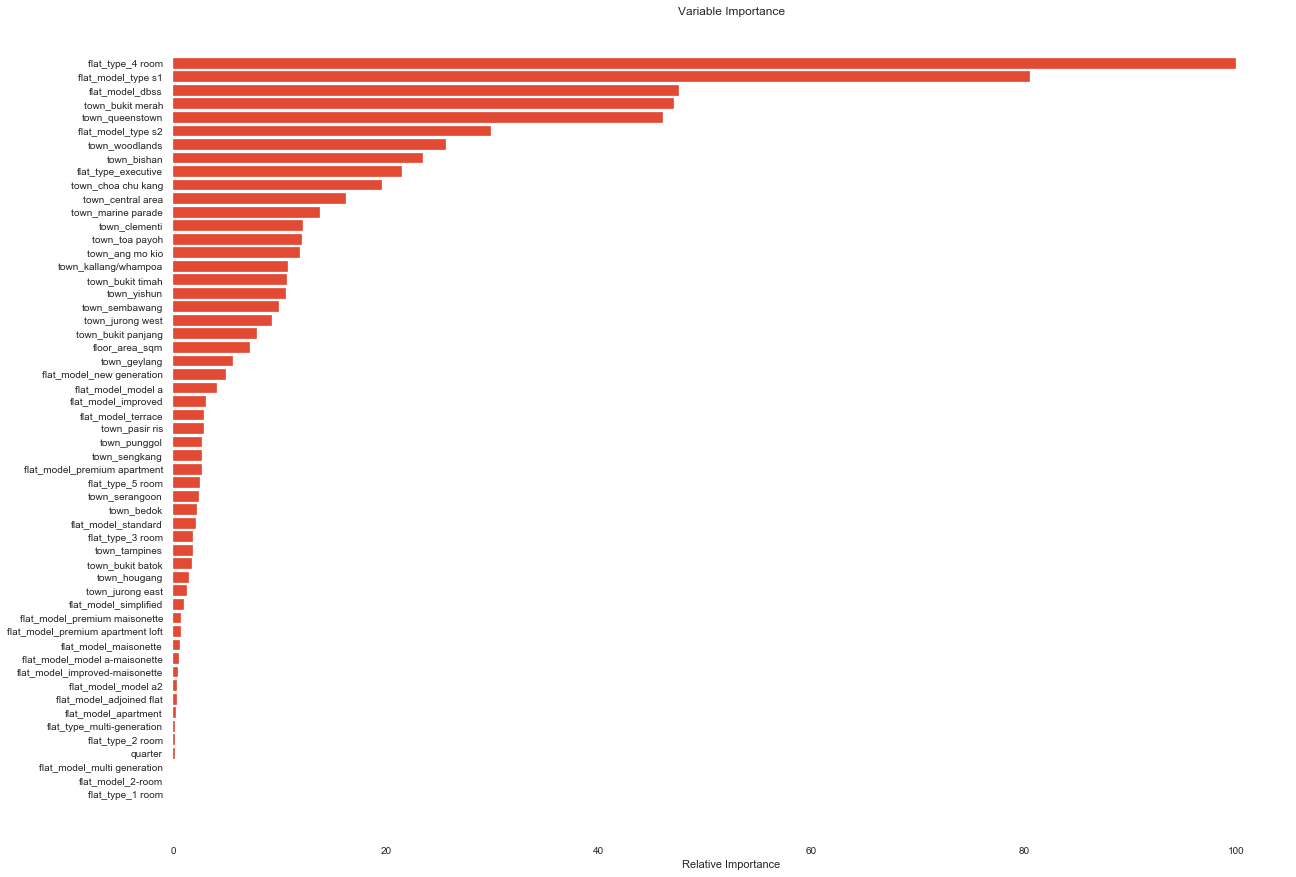

In [19]:
feature_importance = xgb_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos        = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(20,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
plt.savefig("feature_importance_xg.png")
plt.clf()
plt.close()

Although the feature importance for decison trees and XGBoost look a little different, on closer inspection we can draw certain conclusions based on the most important features in each. <br>
By looking at the feature importance matrix of both the algorithms, we can confirm that indeed 'floor_area_sqm' , 'flat_type', 'flat_model' and 'town' are the features that influence the resale price the most. <br>
If I had more time, I would have worked on these features and built better algorithms according to everything I learned during exploratory analysis of this dataset. 

# Testing Data

In [254]:
X_test

,street_name_0,street_name_1,street_name_2,street_name_3,street_name_4,street_name_5,street_name_6,street_name_7,street_name_8,street_name_9,...,flat_model_multi generation,flat_model_new generation,flat_model_premium apartment,flat_model_premium apartment loft,flat_model_premium maisonette,flat_model_simplified,flat_model_standard,flat_model_terrace,flat_model_type s1,flat_model_type s2
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2019-01-01,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2019-01-01,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2019-01-01,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2019-01-01,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2019-01-01,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2019-01-01,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2019-01-01,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2019-01-01,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [255]:
y_test

Datetime
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
2019-01-01    1.0
             ... 
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2020-01-01    1.0
2